In [20]:
import numpy as np
import cv2
import pathlib
import os
from matplotlib import pyplot as plt

In [40]:
img1 = cv2.imread('non_mask/0.png',0)  #queryimage # left image
img2 = cv2.imread('non_mask/2.png',0) #trainimage # right image

sift = cv2.SIFT_create()

# SIFTを使った特徴点検出と特徴量の計算
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# 対応点探索のためのFLANNのパラメータ設定
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

    # 対応点検出
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# Loweの論文に記載されている特徴量の類似度の比に基づくマッチングの評価
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [41]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
# 外れ値を取り除きます

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# 外れ値を取り除きます
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [45]:
print(F)

[[ 5.70744277e-07 -1.04080693e-06  6.55821568e-04]
 [ 1.07562181e-06  7.03896869e-07 -1.35811147e-03]
 [-1.62552296e-03  1.76132598e-05  1.00000000e+00]]


In [42]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - img2上の点に対応するエピポーラ線を描画する画像
        lines - 対応するエピポーラ線 '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

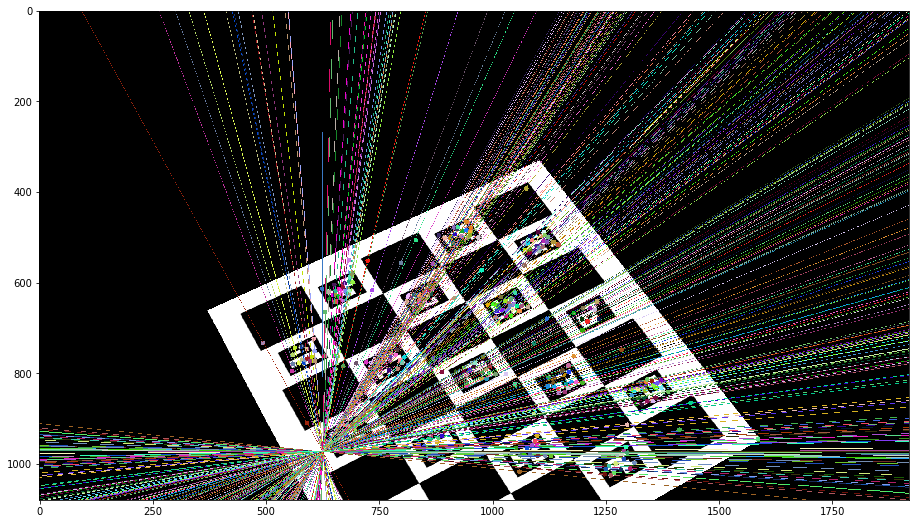

In [43]:
# 右画像(二番目の画像)中の点に対応するエピポーラ線の計算
# 計算したエピポーラ線を左画像に描画
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# 左画像(一番目の画像)中の点に対応するエピポーラ線の計算
# 計算したエピポーラ線を右画像に描画
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

    # 結果の表示
#plt.subplot(121),plt.imshow(img5)
#plt.subplot(122),plt.imshow(img3)

plt.figure(figsize=(16, 9))
plt.imshow(img5)

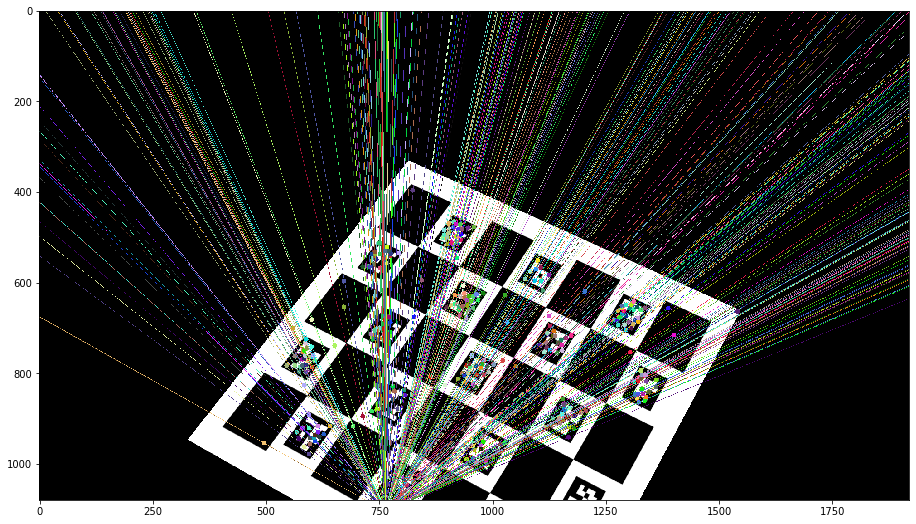

In [44]:
plt.figure(figsize=(16, 9))
plt.imshow(img3)